#**Importing the required libraries**

In [1]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import itertools

## Connecting to Google Drive

In [2]:
#Start by connecting gdrive into the google colab

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading Dataset

In [4]:
# Paths for data.
Ravdess = "/content/gdrive/MyDrive/AudioDataset/RAVDESS/audio_speech_actors_01-24"

In [5]:
os.chdir('/content/gdrive/MyDrive/AudioDataset')

# **Ravdess dataset**

The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) Dataset is a multimodal database of emotional speech and song that has been verified. The database is gender balanced, with 24 professional actors performing lexically-matched utterances in a neutral North American accent.

  Emotions:
  
      01 = neutral
      02 = calm
      03 = happy
      04 = sad
      05 = angry
      06 = fearful
      07 = disgust
      08 = surprised

In [6]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotion,Path
0,sad,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
1,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
2,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
3,sad,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
4,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...


In [7]:
# creating Dataframes for the dataframe that we used
data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.shape

(1440, 2)

In [8]:
data_path.head(10)

,Emotion,Path
0,sad,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
1,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
2,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
3,sad,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
4,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
5,happy,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
6,happy,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
7,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
8,happy,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
9,happy,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...


#**Data Exploration**
Barchart is utilised to plot the count of each emotions in our dataset.

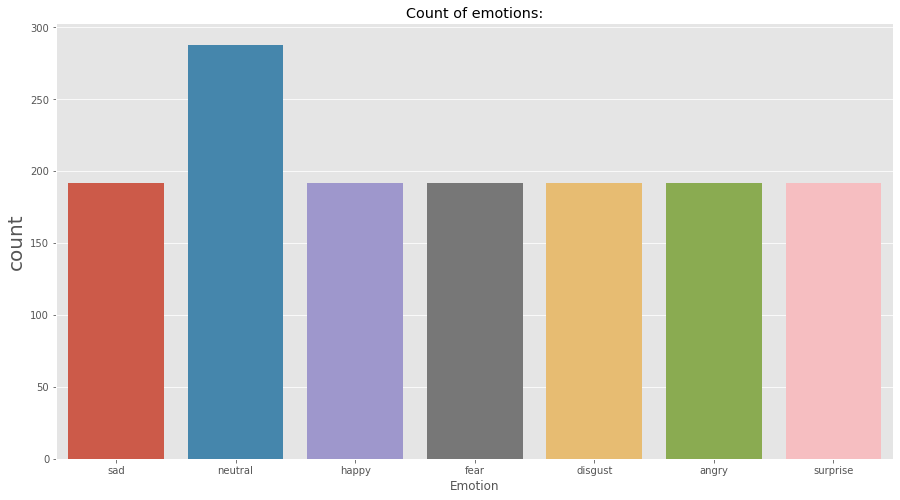

In [9]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,8)
plt.style.use("ggplot")
plt.ylabel('Count', size=20)
plt.title("Count of emotions:")
sns.countplot(x=data_path["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

#**Waveplots and Spectograms for audio signals.**


*   Waveplots - Waveplots let us know the loudness of the audio at a given time.
*   Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.





In [10]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

The wave plot below is a graphical depiction of the vibration of a sound wave over time. It is in this wave that we must look for the key pattern that will allow us to discriminate between the various emotions.

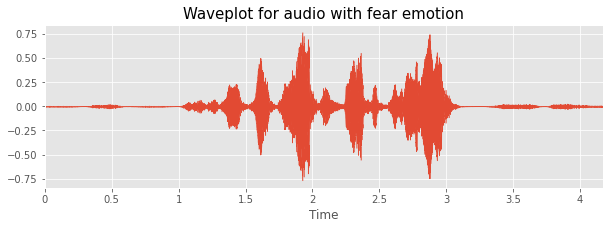

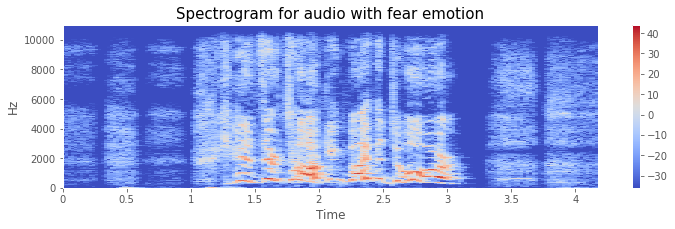

In [11]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

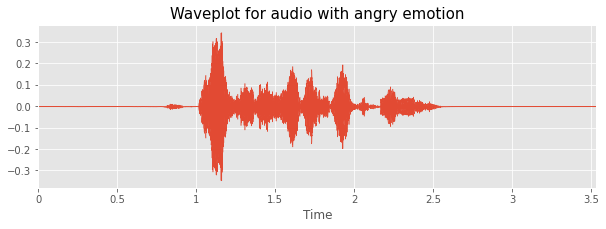

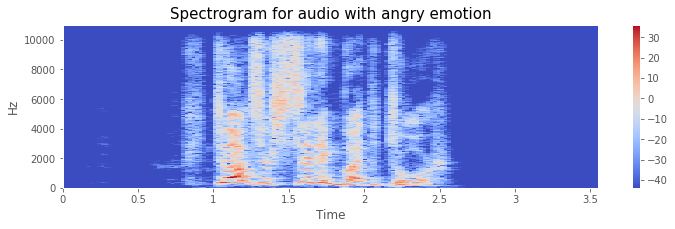

In [12]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

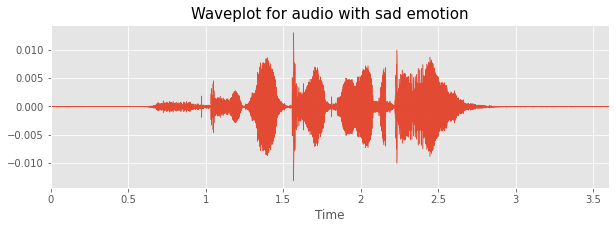

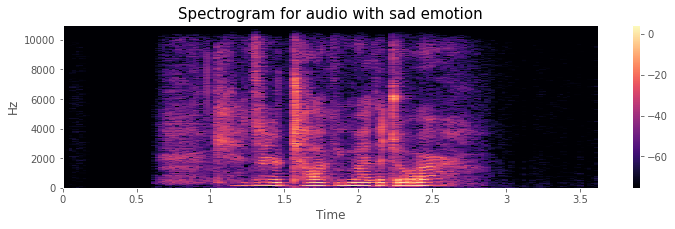

In [13]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#**Data Augmentation**

Data augmentation is use for the process of creating fresh synthetic data samples by making tiny changes to the existing training set.

**Techniques Used**

*   Noise injection

*   Stretching

*   Shifting

*   Pitching


In [14]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [15]:
data_path.head()

,Emotion,Path
0,sad,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
1,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
2,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
3,sad,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...
4,neutral,/content/gdrive/MyDrive/AudioDataset/RAVDESS/a...


In [16]:
path = data_path[data_path["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

**1. Simple Audio**

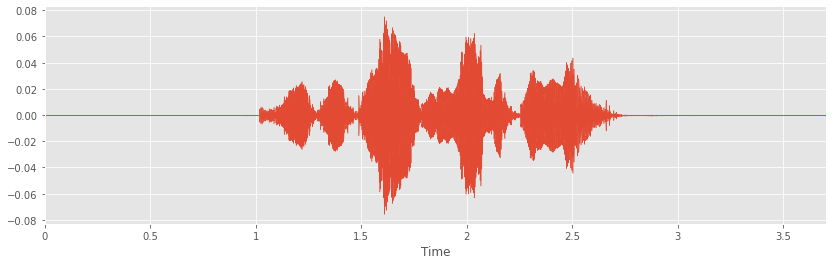

In [17]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(data, sampling_rate)
Audio(path)

**2. Noise Injection**

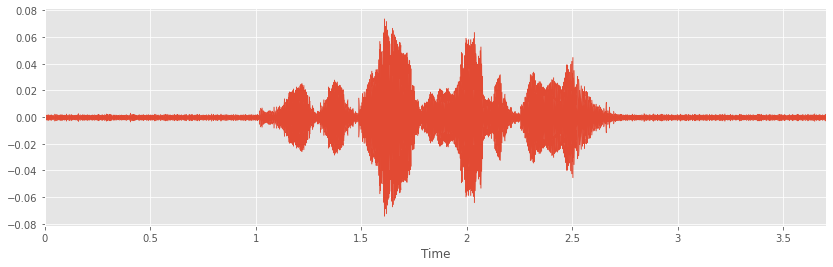

In [18]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=noised_data, sr=sampling_rate)
Audio(noised_data, rate=sampling_rate)

**3. Stretching**

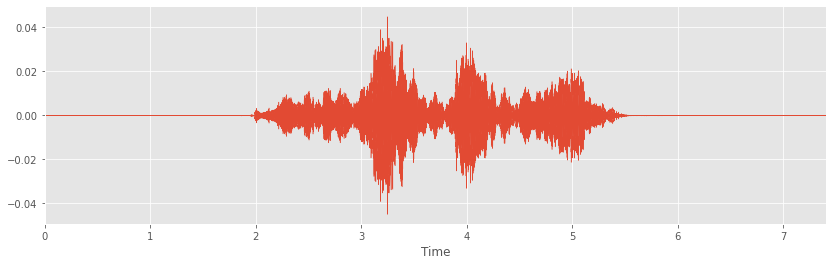

In [19]:
stretched_data = stretch(data, rate=0.5)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=stretched_data, sr=sampling_rate)
Audio(stretched_data, rate=sampling_rate)

**4. Shifting**

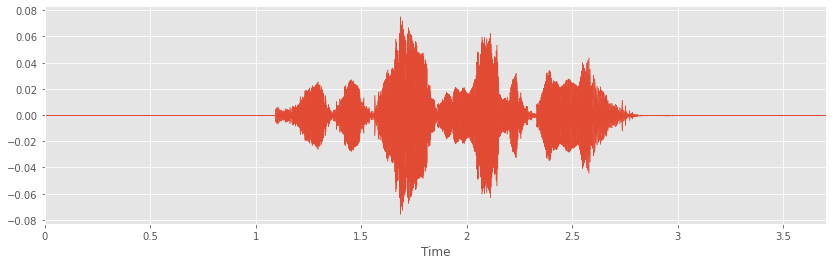

In [20]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=shifted_data, sr=sampling_rate)
Audio(shifted_data, rate=sampling_rate)

**5. Pitch**

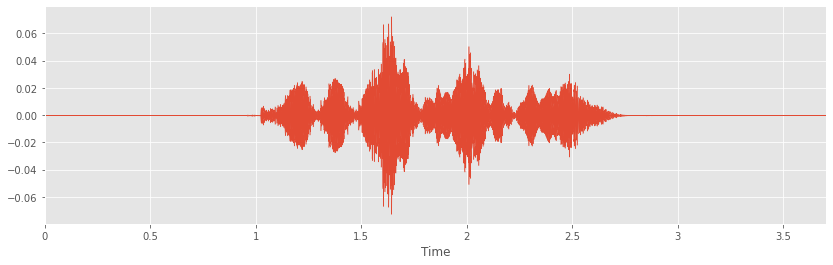

In [21]:
pitched_data = pitch(data, sampling_rate, pitch_factor=0.5, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=pitched_data, sr=sampling_rate)
Audio(pitched_data, rate=sampling_rate)

#**Feature Extraction**

The extraction of features is a step in discovering insights between various attributes.

Audio data must be transform into a comprehensible format, which is where feature extraction comes in.

In [22]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

**Let's check data formats:**

In [23]:
path = np.array(data_path["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

55125

In [24]:
print("ZCR: ", zcr(data).shape)
print("Energy: ", energy(data).shape)
print("Entropy of Energy :", entropy_of_energy(data).shape)
print("RMS :", rmse(data).shape)
print("Spectral Centroid :", spc(data, sampling_rate).shape)
print("Spectral Flux: ", spc_flux(data).shape)
print("Spectral Rollof: ", spc_rollof(data, sampling_rate).shape)
print("Chroma STFT: ", chroma_stft(data, sampling_rate).shape)
print("MelSpectrogram: ", mel_spc(data, sampling_rate).shape)
print("MFCC: ", mfcc(data, sampling_rate).shape)

ZCR:  (108,)
Energy:  (108,)
Entropy of Energy : (108,)
RMS : (108,)
Spectral Centroid : (108,)
Spectral Flux:  ()
Spectral Rollof:  (108,)
Chroma STFT:  (1296,)
MelSpectrogram:  (13824,)
MFCC:  (2160,)


In an experimental approach, it was determined to utilize only three important features for this task: ZCR, RMS, and MFCC.

It was also chosen in an experimental way to utilize just 2.5s duration with 0.6 offset - in the dataset, the first 0.6s include no information regarding emotion, and most of them are smaller than 3s.

In [25]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [26]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate, random=True)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate, random=True)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [27]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(data_path.Path, data_path.Emotion, range(data_path.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
Done.


**Saving features as DataFrame to CSV format for further processing:**

In [28]:
features_path = "features.csv"

In [29]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.626905,-7.094075,-4.512566,-14.473028,-0.065663,-3.934443,8.424742,0.178797,-6.139037,sad
1,0.242676,0.374512,0.508301,0.503906,0.513672,0.520508,0.512695,0.518066,0.525391,0.506348,...,-4.495385,-6.939227,-4.579755,-14.545831,0.103636,-3.996514,8.409430,-0.039812,-5.860249,sad
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.054097,-3.316967,-4.248488,-8.542223,-0.112963,4.048573,11.531116,1.893085,-1.544590,sad
3,0.245117,0.372070,0.502930,0.514648,0.500977,0.506836,0.494629,0.494141,0.516113,0.508301,...,2.453225,4.789970,5.425672,0.398458,-0.776027,-6.104277,-2.381964,-0.081319,-0.003715,sad
4,0.000000,0.000000,0.000000,0.000000,0.033203,0.045898,0.045898,0.045898,0.012207,0.104492,...,-0.014572,1.854240,11.185823,1.506837,2.114448,-0.605264,-1.920638,1.007989,-5.359728,neutral


In [30]:
extracted_df = pd.read_csv(features_path)
print(extracted_df.shape)

(5760, 2377)


In [31]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(5760, 2377)

In [32]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-4.626905,-7.094075,-4.512566,-14.473028,-0.065663,-3.934443,8.424742,0.178797,-6.139037,sad
1,0.242676,0.374512,0.508301,0.503906,0.513672,0.520508,0.512695,0.518066,0.525391,0.506348,...,-4.495385,-6.939227,-4.579755,-14.545831,0.103636,-3.996514,8.409430,-0.039812,-5.860249,sad
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-6.054097,-3.316967,-4.248488,-8.542223,-0.112963,4.048573,11.531116,1.893085,-1.544590,sad
3,0.245117,0.372070,0.502930,0.514648,0.500977,0.506836,0.494629,0.494141,0.516113,0.508301,...,2.453225,4.789970,5.425672,0.398458,-0.776027,-6.104277,-2.381964,-0.081319,-0.003715,sad
4,0.000000,0.000000,0.000000,0.000000,0.033203,0.045898,0.045898,0.045898,0.012207,0.104492,...,-0.014572,1.854240,11.185823,1.506837,2.114448,-0.605264,-1.920638,1.007989,-5.359728,neutral


#**Data Preparation**
After extracting date, the data must be nornalised and split into for training and testing sets.

In [33]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [34]:
lb = LabelEncoder()
Y = np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4608, 2376), (1152, 2376), (4608, 7), (1152, 7))

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4147, 2376), (1152, 2376), (461, 2376), (4147, 7), (1152, 7), (461, 7))

In [37]:
# Standardize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((4147, 2376), (1152, 2376), (461, 2376), (4147, 7), (1152, 7), (461, 7))

In [38]:
# 1-dimensional CNN applied to model:
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(4147, 2376, 1)

In [39]:
earlystopping = EarlyStopping(monitor ="val_acc",
                              mode = 'auto', patience = 5,
                              restore_best_weights = True)

In [40]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [41]:
# checkpointer = ModelCheckpoint(filepath = 'finalmodel.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='min')

## **Defining Model**

In [42]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
model = models.Sequential()
model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(512, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=5, strides=1,
                        padding="same", activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(7, activation="softmax"))

model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["acc"])

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 512)         3072      
                                                                 
 batch_normalization (BatchN  (None, 2376, 512)        2048      
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 512)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 512)         1311232   
                                                                 
 batch_normalization_1 (Batc  (None, 1188, 512)        2048      
 hNormalization)                                                 
                                                        

## **Model Training**

In [45]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=64,
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/50
65/65 [==============================] - 39s 345ms/step - loss: 1.8328 - acc: 0.4104 - val_loss: 9.1276 - val_acc: 0.2082 - lr: 0.0010
Epoch 2/50
65/65 [==============================] - 21s 327ms/step - loss: 1.1664 - acc: 0.5819 - val_loss: 5.5971 - val_acc: 0.2082 - lr: 0.0010
Epoch 3/50
65/65 [==============================] - 22s 336ms/step - loss: 0.7487 - acc: 0.7446 - val_loss: 5.0161 - val_acc: 0.1302 - lr: 0.0010
Epoch 4/50
65/65 [==============================] - 21s 326ms/step - loss: 0.4627 - acc: 0.8454 - val_loss: 3.4171 - val_acc: 0.2126 - lr: 0.0010
Epoch 5/50
65/65 [==============================] - 21s 325ms/step - loss: 0.2782 - acc: 0.9156 - val_loss: 5.4331 - val_acc: 0.2798 - lr: 0.0010
Epoch 6/50
65/65 [==============================] - 21s 325ms/step - loss: 0.1854 - acc: 0.9438 - val_loss: 4.7794 - val_acc: 0.2820 - lr: 0.0010
Epoch 7/50
65/65 [==============================] - 21s 328ms/step - loss: 0.1175 - acc: 0.9706 - val_loss: 1.6438 - val_acc

## **Model Evaluation**

36/36 [==============================] - 2s 48ms/step - loss: 0.3979 - acc: 0.9036
Accuracy of our model on test data :  90.36458134651184 %


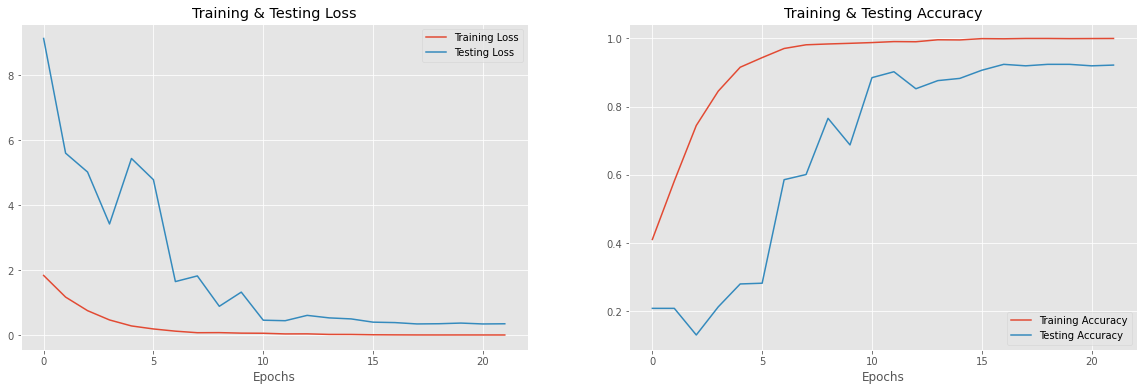

In [46]:
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
test_acc = history.history['val_acc']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(train_loss, label = 'Training Loss')
ax[0].plot(test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(train_acc, label = 'Training Accuracy')
ax[1].plot(test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [47]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

36/36 [==============================] - 2s 47ms/step


array([4, 4, 4, ..., 5, 6, 6])

In [48]:
y_check = np.argmax(y_test, axis=1)
y_check

array([4, 4, 4, ..., 5, 6, 6])

In [49]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

In [50]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[110   4   1   5   1   1   0]
 [  0 149   3   1   6   2   1]
 [  3   3 139   5   6   5   2]
 [  1   0   4 140   6   0   3]
 [  0   0   0   3 216   6   0]
 [  1   5   8   1   7 152   0]
 [  3   2   5   7   0   0 135]]


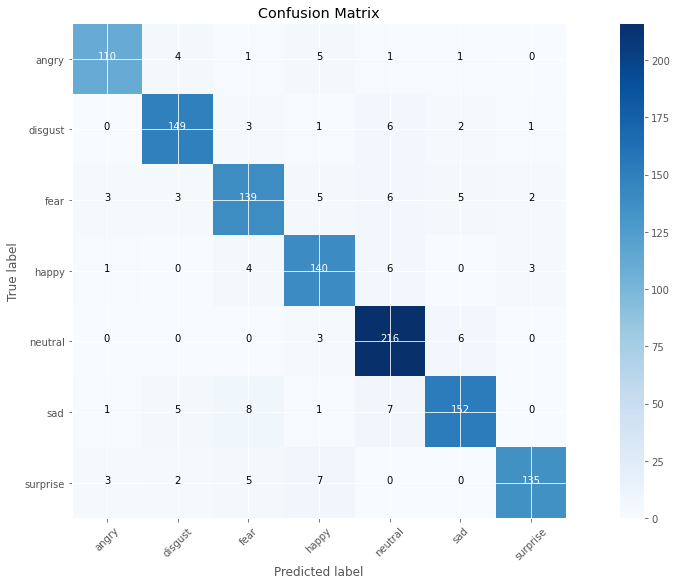

In [51]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## **Exporting the model**

The last step is exporting the  model to be used on embedded devices or on the browser.



In [52]:
path_to_model = "model.hdf5"

model.save(path_to_model)

In [53]:
model.save(filepath="save_model/")

In [54]:
model.save('finalmodel.hdf5')